# PART A: DATA PREPROCESSING - MICROCLIMATE SENSOR DATA

In [2]:
# Import Required Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, classification_report, adjusted_rand_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

### 1. Load the Dataset

In [4]:
microclimate_df = pd.read_csv('Microclimate_sensors_data.csv')

In [5]:
microclimate_df.head()

,Device_id,Time,SensorLocation,LatLong,MinimumWindDirection,AverageWindDirection,MaximumWindDirection,MinimumWindSpeed,AverageWindSpeed,GustWindSpeed,AirTemperature,RelativeHumidity,AtmosphericPressure,PM25,PM10,Noise
0,ICTMicroclimate-08,2025-06-08T11:01:12+10:00,Swanston St - Tram Stop 13 adjacent Federation...,"-37.8184515, 144.9678474",0.0,201.0,354.0,0.0,0.8,2.0,10.3,87.600000,1001.100000,2.0,5.0,73.400000
1,ICTMicroclimate-02,2025-06-08T11:01:45+10:00,101 Collins St L11 Rooftop,"-37.814604, 144.9702991",0.0,337.0,341.0,0.0,0.4,0.9,9.9,96.400000,996.000000,7.0,9.0,69.200000
2,ICTMicroclimate-01,2025-06-08T11:06:09+10:00,Birrarung Marr Park - Pole 1131,"-37.8185931, 144.9716404",NaN,15.0,NaN,NaN,0.2,NaN,9.0,95.800003,999.900024,1.0,4.0,52.799999
3,ICTMicroclimate-06,2025-06-08T11:14:42+10:00,Tram Stop 7B - Melbourne Tennis Centre Precinc...,"-37.8194993, 144.9787211",0.0,85.0,359.0,0.0,0.7,5.0,10.4,88.700000,1000.700000,1.0,2.0,72.200000
4,ICTMicroclimate-10,2025-06-08T11:15:15+10:00,1 Treasury Place,"-37.8128595, 144.9745395",0.0,57.0,356.0,0.0,0.3,0.6,9.3,98.800000,997.200000,1.0,3.0,82.100000


In [6]:
print("Number of missing values in each feature:\n")
print(microclimate_df.isnull().sum())

Number of missing values in each feature:

Device_id                   0
Time                        0
SensorLocation           6143
LatLong                 11483
MinimumWindDirection    38805
AverageWindDirection      501
MaximumWindDirection    38963
MinimumWindSpeed        38963
AverageWindSpeed          501
GustWindSpeed           38963
AirTemperature            501
RelativeHumidity          501
AtmosphericPressure       501
PM25                    18334
PM10                    18334
Noise                   18334
dtype: int64


*In this step, we load the microclimate sensor dataset and check the number of missing values for each feature.  
This helps identify which columns need data cleaning before further processing.*

## 2. Fill in the missing entries

In [9]:
replacement_values = {}

for col in microclimate_df.columns:
    if microclimate_df[col].isnull().sum() > 0:
        if microclimate_df[col].dtype in ['float64', 'int64']:
            skewness = microclimate_df[col].skew()
            if abs(skewness) > 1:
                replacement = microclimate_df[col].median()
                method = "median"
                reason = f"High skewness ({skewness:.2f}) → median chosen."
            else:
                replacement = microclimate_df[col].mean()
                method = "mean"
                reason = f"Low skewness ({skewness:.2f}) → mean chosen."
        else:
            replacement = microclimate_df[col].mode()[0]
            method = "mode"
            reason = "Categorical feature → mode chosen."
        
        microclimate_df[col].fillna(replacement, inplace=True)
        replacement_values[col] = {
            "replacement": replacement,
            "method": method,
            "reason": reason
        }

print("\n Replacement Summary:\n")
for col, info in replacement_values.items():
    print(f"- {col}: {info['method']} = {info['replacement']} | {info['reason']}")



 Replacement Summary:

- SensorLocation: mode = 1 Treasury Place | Categorical feature → mode chosen.
- LatLong: mode = -37.8185931, 144.9716404 | Categorical feature → mode chosen.
- MinimumWindDirection: median = 0.0 | High skewness (3.19) → median chosen.
- AverageWindDirection: mean = 166.44210668110426 | Low skewness (0.16) → mean chosen.
- MaximumWindDirection: median = 353.0 | High skewness (-1.84) → median chosen.
- MinimumWindSpeed: median = 0.0 | High skewness (8.49) → median chosen.
- AverageWindSpeed: median = 0.8 | High skewness (1.68) → median chosen.
- GustWindSpeed: median = 2.8 | High skewness (1.71) → median chosen.
- AirTemperature: mean = 16.442229732245508 | Low skewness (0.58) → mean chosen.
- RelativeHumidity: mean = 66.37330485582173 | Low skewness (-0.55) → mean chosen.
- AtmosphericPressure: median = 1014.7 | High skewness (-8.38) → median chosen.
- PM25: median = 3.0 | High skewness (8.14) → median chosen.
- PM10: median = 5.0 | High skewness (8.56) → median

In [10]:
# Print final summary
print("\n Missing Value Replacement Summary:\n")
for col, details in replacement_values.items():
    print(f"Feature: {col}")
    print(f"  Replacement Value: {details['replacement']}")
    print(f"  Method Used: {details['method']}")
    print(f"  Reason: {details['reason']}\n")


 Missing Value Replacement Summary:

Feature: SensorLocation
  Replacement Value: 1 Treasury Place
  Method Used: mode
  Reason: Categorical feature → mode chosen.

Feature: LatLong
  Replacement Value: -37.8185931, 144.9716404
  Method Used: mode
  Reason: Categorical feature → mode chosen.

Feature: MinimumWindDirection
  Replacement Value: 0.0
  Method Used: median
  Reason: High skewness (3.19) → median chosen.

Feature: AverageWindDirection
  Replacement Value: 166.44210668110426
  Method Used: mean
  Reason: Low skewness (0.16) → mean chosen.

Feature: MaximumWindDirection
  Replacement Value: 353.0
  Method Used: median
  Reason: High skewness (-1.84) → median chosen.

Feature: MinimumWindSpeed
  Replacement Value: 0.0
  Method Used: median
  Reason: High skewness (8.49) → median chosen.

Feature: AverageWindSpeed
  Replacement Value: 0.8
  Method Used: median
  Reason: High skewness (1.68) → median chosen.

Feature: GustWindSpeed
  Replacement Value: 2.8
  Method Used: median


*Here, we handle missing data by analyzing each feature’s data type and skewness:*

*- **Numeric features:** If the feature is highly skewed (|skewness| > 1), we use the median to avoid the influence of outliers. 
  Otherwise, the mean is used.*
  
*- **Categorical features:** The mode (most frequent value) is used to fill missing entries.*

*This approach ensures that missing values are replaced logically based on the nature of the data.*
*A summary is printed showing the method, value, and reasoning for each replacement.*

## 3. Split 'LatLong' into 'Latitude' and 'Longitude'

In [13]:
# Split the 'LatLong' string on the comma

microclimate_df[['Latitude', 'Longitude']] = microclimate_df['LatLong'].str.split(',', expand=True)

In [14]:
# Convert the split strings to numeric (float)

microclimate_df['Latitude'] = pd.to_numeric(microclimate_df['Latitude'])
microclimate_df['Longitude'] = pd.to_numeric(microclimate_df['Longitude'])

In [15]:
# Drop the 'LatLong' column since it's no longer required

microclimate_df.drop('LatLong', axis=1, inplace=True)

In [16]:
print("'LatLong' has been split and encoded as numerical Latitude and Longitude:\n")
print(microclimate_df[['Latitude', 'Longitude']].head())

'LatLong' has been split and encoded as numerical Latitude and Longitude:

    Latitude   Longitude
0 -37.818452  144.967847
1 -37.814604  144.970299
2 -37.818593  144.971640
3 -37.819499  144.978721
4 -37.812860  144.974539


*The `'LatLong'` column contains combined latitude and longitude as a single string.  
Here, we split this column into two separate numeric columns: `'Latitude'` and `'Longitude'`.  
The original `'LatLong'` column is then dropped to avoid duplication.  
This makes the location data easier to interpret and use for analysis.*

## 4. Apply Min-Max scaling on continuous features

In [19]:
#Select numeric columns 
numeric_columns = microclimate_df.select_dtypes(include=['float64', 'int64']).columns.tolist()

In [20]:
print(f"Continuous features to scale: {numeric_columns}")

Continuous features to scale: ['MinimumWindDirection', 'AverageWindDirection', 'MaximumWindDirection', 'MinimumWindSpeed', 'AverageWindSpeed', 'GustWindSpeed', 'AirTemperature', 'RelativeHumidity', 'AtmosphericPressure', 'PM25', 'PM10', 'Noise', 'Latitude', 'Longitude']


In [21]:
#scaling the data
scaler = MinMaxScaler()

In [22]:
#Fit and transform the numeric columns
microclimate_scaled = microclimate_df.copy()
microclimate_scaled[numeric_columns] = scaler.fit_transform(microclimate_df[numeric_columns])

In [23]:
print("\n Head of scaled continuous features:\n")
print(microclimate_scaled[numeric_columns].head())


 Head of scaled continuous features:

   MinimumWindDirection  AverageWindDirection  MaximumWindDirection  \
0                   0.0              0.559889              0.983333   
1                   0.0              0.938719              0.947222   
2                   0.0              0.041783              0.980556   
3                   0.0              0.236769              0.997222   
4                   0.0              0.158774              0.988889   

   MinimumWindSpeed  AverageWindSpeed  GustWindSpeed  AirTemperature  \
0               0.0          0.072072       0.038095        0.266827   
1               0.0          0.036036       0.017143        0.257212   
2               0.0          0.018018       0.053333        0.235577   
3               0.0          0.063063       0.095238        0.269231   
4               0.0          0.027027       0.011429        0.242788   

   RelativeHumidity  AtmosphericPressure      PM25      PM10     Noise  \
0          0.872651        

*We applied Min-Max scaling to continuous features to transform them to a common scale [0, 1].  
*This ensures that features with larger ranges do not dominate distance-based algorithms like clustering or PCA.  
*The shape of the feature’s distribution remains the same — only the scale changes.

## 5. Plot distribution before vs after

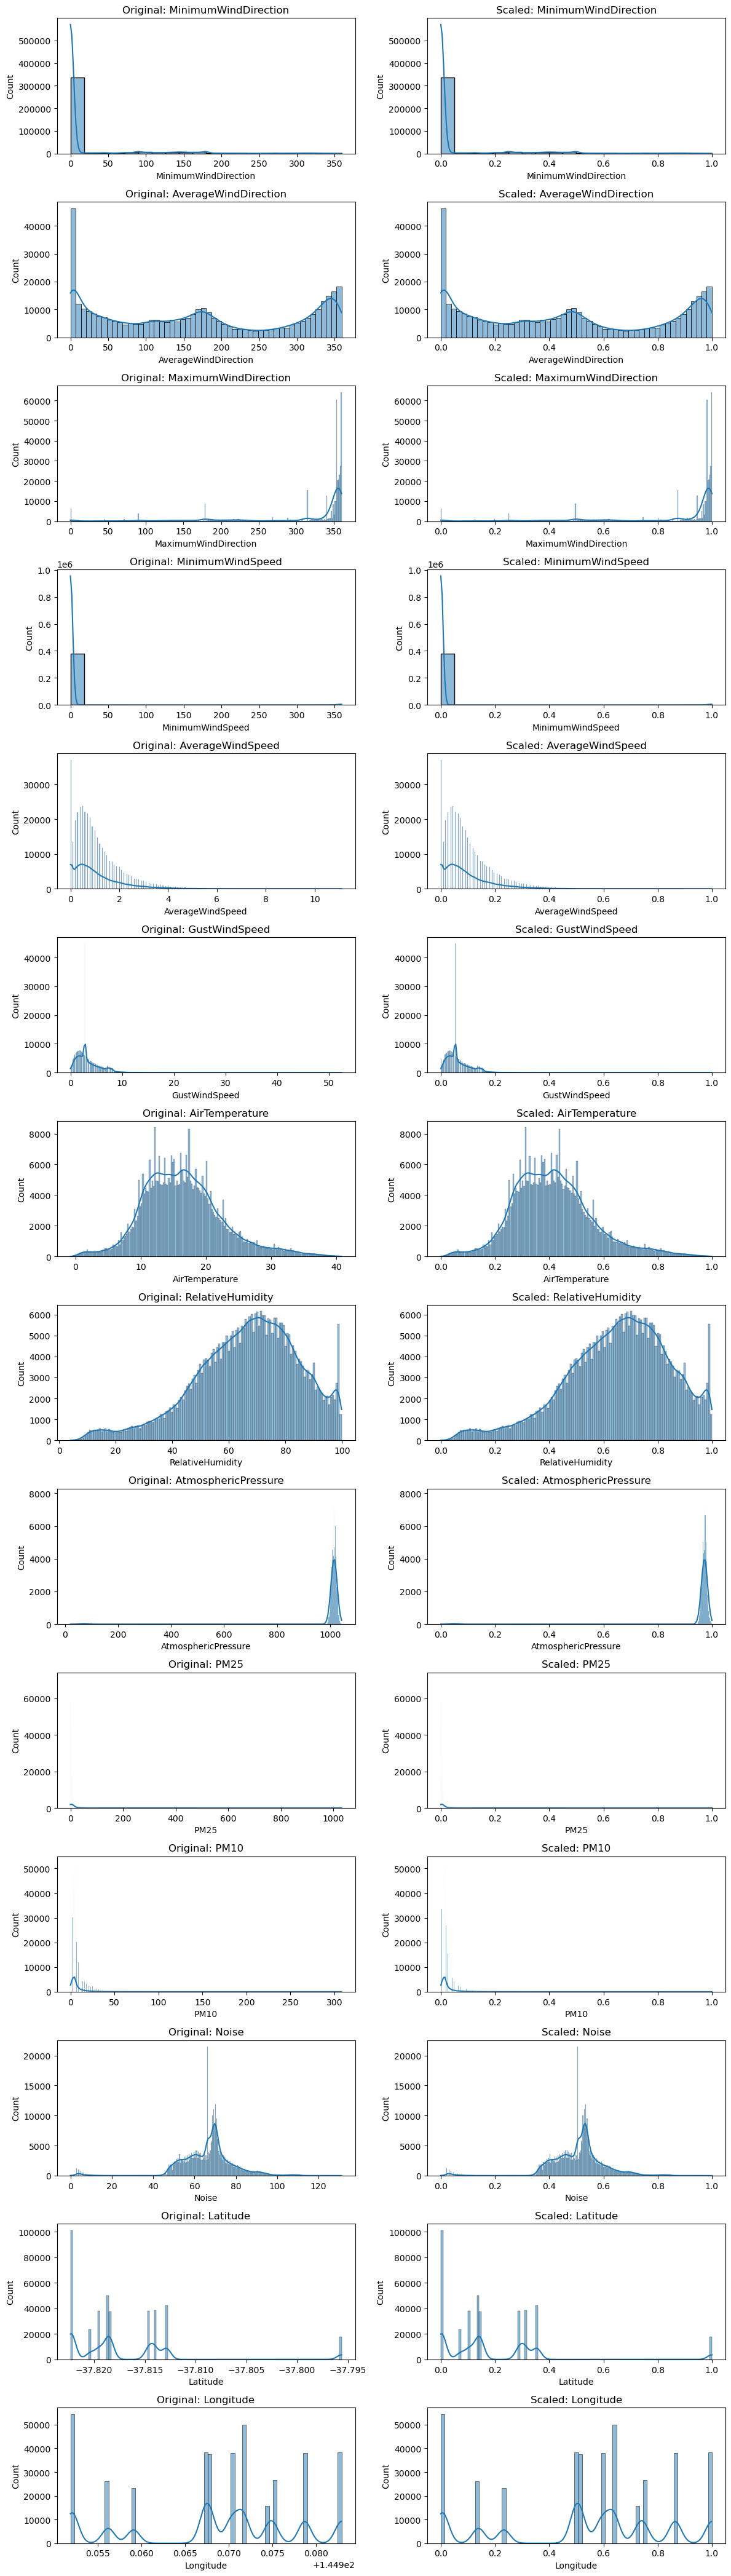

In [26]:
# Create subplots: (original, scaled)

fig, axes = plt.subplots(len(numeric_columns), 2, figsize=(12, len(numeric_columns) * 3))

for i, col in enumerate(numeric_columns):
    # Original
    sns.histplot(microclimate_df[col], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f"Original: {col}")

    # Scaled
    sns.histplot(microclimate_scaled[col], kde=True, ax=axes[i, 1])
    axes[i, 1].set_title(f"Scaled: {col}")

plt.tight_layout()
plt.show()

**Observation:**  

From the plots, we can see that Min-Max scaling has transformed each continuous feature to the [0, 1] range.  
The overall shape and distribution (e.g., skewness, peaks) remain the same — only the scale changes.  
This ensures all features contribute equally to distance-based algorithms like KMeans or PCA.

# Part B: Clustering and PCA

## 6. Load Obesity dataset and remove the class label "NObeyesdad". 

In [30]:
# Load the dataset
obesity_df = pd.read_csv('Obesity_data.csv')

In [31]:
obesity_df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [32]:
# Remove the target class label
obesity_new = obesity_df.drop('NObeyesdad', axis=1)

In [33]:
print("\n 'NObeyesdad' label removed. Remaining columns:\n" , obesity_new.columns.tolist())


 'NObeyesdad' label removed. Remaining columns:
 ['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS']


In [34]:
obesity_new.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation


## 7. Encode the categorical features using appropriate techniques. 

In [36]:
# Copy the dataset
obesity_encoded = obesity_new.copy()

In [37]:
# Find categorical columns
categorical_columns = obesity_encoded.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", categorical_columns)

Categorical columns: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']


### Label Encoding for binary categorical columns

In [39]:
# Identify binary categorical columns (with only 2 unique values)
binary_columns = [col for col in categorical_columns if obesity_encoded[col].nunique() == 2]

print(f"Binary categorical columns: {binary_columns}")

Binary categorical columns: ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']


In [40]:
# Apply Label Encoding to binary columns
le = LabelEncoder()

In [41]:
for col in binary_columns:
    obesity_encoded[col] = le.fit_transform(obesity_encoded[col])

**Explanation:**  
Binary categorical features (those with only two unique categories) were Label Encoded.  
This maps each category to 0 or 1, making them numeric for clustering.

### One-Hot Encoding for multi-category columns

In [44]:
# Identify multi-category columns (more than 2 unique values)
multi_cat_columns = [col for col in categorical_columns if obesity_new[col].nunique() > 2]

In [45]:
# Apply One-Hot Encoding for each multi-category column
obesity_encoded = pd.get_dummies(obesity_encoded, columns=multi_cat_columns, prefix=multi_cat_columns)

In [46]:
print("Final encoded dataset sample:\n")
print(obesity_encoded.head())

Final encoded dataset sample:

   Gender   Age  Height  Weight  family_history_with_overweight  FAVC  FCVC  \
0       0  21.0    1.62    64.0                               1     0   2.0   
1       0  21.0    1.52    56.0                               1     0   3.0   
2       1  23.0    1.80    77.0                               1     0   2.0   
3       1  27.0    1.80    87.0                               0     0   3.0   
4       1  22.0    1.78    89.8                               0     0   2.0   

   NCP  SMOKE  CH2O  ...  CAEC_no  CALC_Always  CALC_Frequently  \
0  3.0      0   2.0  ...    False        False            False   
1  3.0      1   3.0  ...    False        False            False   
2  3.0      0   2.0  ...    False        False             True   
3  3.0      0   2.0  ...    False        False             True   
4  1.0      0   2.0  ...    False        False            False   

   CALC_Sometimes  CALC_no  MTRANS_Automobile  MTRANS_Bike  MTRANS_Motorbike  \
0          

**Explanation:**  
Multi-category features were One-Hot Encoded.  
Each unique category became its own column with binary indicators (0 or 1).  
This avoids any false ordering in categorical data.

## 8. Use the Silhouette Coefficient to determine the optimal number of clusters (k). 

In [49]:
X = obesity_encoded.copy()

In [50]:
# Range of k 
k_range = range(2, 10) 

In [51]:
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)
    print(f"k = {k}, Silhouette Coefficient = {score:.4f}")

k = 2, Silhouette Coefficient = 0.5688
k = 3, Silhouette Coefficient = 0.5034
k = 4, Silhouette Coefficient = 0.4736
k = 5, Silhouette Coefficient = 0.4212
k = 6, Silhouette Coefficient = 0.4486
k = 7, Silhouette Coefficient = 0.4096
k = 8, Silhouette Coefficient = 0.4093
k = 9, Silhouette Coefficient = 0.4070


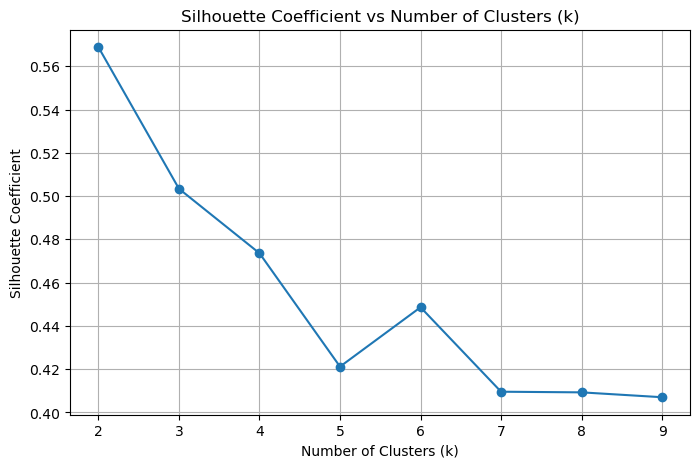

In [52]:
# Plot Silhouette scores vs k
plt.figure(figsize=(8,5))
plt.plot(list(k_range), silhouette_scores, marker='o')
plt.title("Silhouette Coefficient vs Number of Clusters (k)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Coefficient")
plt.grid(True)
plt.show()

In [53]:
# Find the best k
best_k = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f"\n Optimal number of clusters (k) based on Silhouette Coefficient: {best_k}")


 Optimal number of clusters (k) based on Silhouette Coefficient: 2


 **Note:**  
The Silhouette Coefficient plot shows a clear peak at k = 2, indicating that two clusters give the best separation based on the input features alone.  

However, because the real-world obesity condition involves multiple levels (underweight, normal weight, overweight, obesi etc.ty), testing k = 3 or k = 4 caprovideve more meaningful insight.
.


## 9. Apply KMeans and KMeans++ for the optimal k

In [56]:
X = obesity_encoded.copy()

In [57]:
k_values = [2, 4]

### KMeans with Random Initialization

In [59]:
results_kmeans = []

for k in k_values:
    kmeans_random = KMeans(n_clusters=k, init='random', random_state=42)
    labels_random = kmeans_random.fit_predict(X)
    inertia_random = kmeans_random.inertia_
    silhouette_random = silhouette_score(X, labels_random)

    results_kmeans.append({
        'k': k,
        'Method': 'KMeans (Random)',
        'Inertia': inertia_random,
        'Silhouette': silhouette_random
    })

results_kmeans_df = pd.DataFrame(results_kmeans)

print("KMeans (Random Init) Results:")
print(results_kmeans_df)

KMeans (Random Init) Results:
   k           Method        Inertia  Silhouette
0  2  KMeans (Random)  502926.681910    0.568812
1  4  KMeans (Random)  196763.139789    0.473893


 ### KMeans++ 

In [61]:
results_kmeans_pp = []

for k in k_values:
    kmeans_plus = KMeans(n_clusters=k, init='k-means++', random_state=42)
    labels_plus = kmeans_plus.fit_predict(X)
    inertia_plus = kmeans_plus.inertia_
    silhouette_plus = silhouette_score(X, labels_plus)

    results_kmeans_pp.append({
        'k': k,
        'Method': 'KMeans++',
        'Inertia': inertia_plus,
        'Silhouette': silhouette_plus
    })

results_kmeans_pp_df = pd.DataFrame(results_kmeans_pp)

print("\nKMeans++ Results:")
print(results_kmeans_pp_df)


KMeans++ Results:
   k    Method        Inertia  Silhouette
0  2  KMeans++  502926.681910    0.568812
1  4  KMeans++  196780.654602    0.473580


### Comparison

In [63]:
results_comparison_df = pd.concat([results_kmeans_df, results_kmeans_pp_df], ignore_index=True)

print("\nClustering Performance Comparison:")
print(results_comparison_df)


Clustering Performance Comparison:
   k           Method        Inertia  Silhouette
0  2  KMeans (Random)  502926.681910    0.568812
1  4  KMeans (Random)  196763.139789    0.473893
2  2         KMeans++  502926.681910    0.568812
3  4         KMeans++  196780.654602    0.473580


**In this step, we applied KMeans clustering on the Obesity dataset using:**
- **Random Initialization**: centroids selected completely at random.
- **KMeans++ Initialization**: smarter centroid initialization that spreads out the starting points.

We tested two values for **k**:
- **k = 2**: based on the highest Silhouette Coefficient.
- **k = 4**: based on a practical assumption that obesity may have more than two natural groups.

**Observations:**
- The Silhouette Coefficient was slightly higher for k = 2, indicating better separation.
- Inertia was lower for k = 4, which is expected with more clusters.
- The performance difference between Random Init and KMeans++ is minimal in this case, suggesting that the clustering result is not very sensitive to initialization.

**Conclusion:**  
KMeans++ is generally preferred for its better centroid initialization, but for this dataset, both methods produced very similar clustering results.


## 10. PCA on Gene Expression Data

In [66]:
gene_df = pd.read_csv("TCGA-PANCAN-HiSeq-801x20531/gene-expression-data.csv")

In [67]:
gene_df.head()

,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


*The dataset contains expression levels for over 20,000 genes across 801 samples.  
It also includes an ID column with sample names (`Unnamed: 0`), which is not required for PCA.*

In [69]:
print("\nDataset shape:", gene_df.shape)


Dataset shape: (801, 20532)


In [70]:
# Drop the first column ('Unnamed: 0' )
X_gene = gene_df.drop(gene_df.columns[0], axis=1)

*Since the first column is just an identifier, we excluded it. PCA should only process numerical gene expression features.*

In [72]:
# Apply PCA
pca = PCA(n_components=3)
X_gene_pca = pca.fit_transform(X_gene)

*Applied PCA to reduce dimensionality
We used scikit-learn’s PCA to reduce the data to **3 principal components**, which capture as much variance as possible in a lower dimension.*

In [74]:
# Report variance explained
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()

In [75]:
print("\nVariance explained by each PC:")
for i, var in enumerate(explained_variance_ratio):
    print(f"PC{i+1}: {var:.4f}")

print("\nCumulative variance explained by first 3 PCs: {:.4f}".format(cumulative_variance[-1]))


Variance explained by each PC:
PC1: 0.1584
PC2: 0.1050
PC3: 0.0947

Cumulative variance explained by first 3 PCs: 0.3581


- The variance ratio explained by each principal component (PC1, PC2, PC3).
- The cumulative variance explained by the first three components.

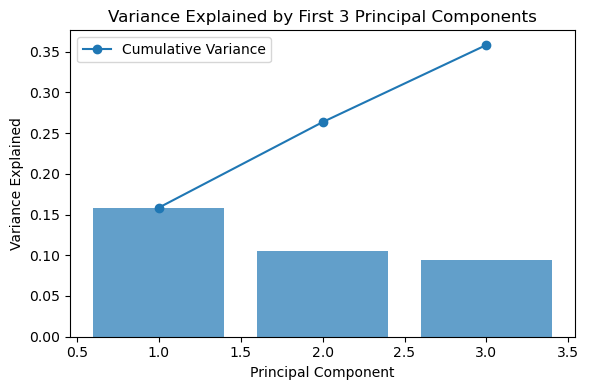

In [77]:
plt.figure(figsize=(6, 4))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7)
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', label='Cumulative Variance')
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.title("Variance Explained by First 3 Principal Components")
plt.legend()
plt.tight_layout()
plt.show()

*The bar chart shows the variance explained by each of the first three principal components (PC1, PC2, and PC3).  
The red line shows the cumulative variance explained when combining these components.*

# 11.  Apply KMeans & Compare with True Labels

In this step, we cluster the gene expression dataset using **KMeans**, using both:
- The **original high-dimensional gene expression data**
- The **PCA-reduced data** (3 principal components)

We compare the clustering results with the true class labels using appropriate unsupervised clustering metrics.

In [81]:
# Load labels

labels_df = pd.read_csv("TCGA-PANCAN-HiSeq-801x20531/labels.csv")

*Load the `labels.csv` file, which contains the true cancer type for each sample (e.g., PRAD, BRCA, LUAD).*


In [83]:
labels_df.head()

,Unnamed: 0,Class
0,sample_0,PRAD
1,sample_1,LUAD
2,sample_2,PRAD
3,sample_3,PRAD
4,sample_4,BRCA


*Check the first few rows to verify the contents.*

In [85]:
# Extract true class labels
y_true = labels_df["Class"]

In [86]:
print("\n Number of unique classes:", len(y_true.unique()))


 Number of unique classes: 5


*Extract the `Class` column to use as the true labels.*

In [88]:
# Apply KMeans on Original Gene Features
kmeans_original = KMeans(
    n_clusters=len(y_true.unique()),
    init="k-means++",
    random_state=42)
y_pred_original = kmeans_original.fit_predict(X_gene)

*Run **KMeans** clustering on the original gene expression dataset.
We use `k` equal to the number of unique classes.*

In [90]:
# Apply KMeans on PCA-Reduced Features
kmeans_pca = KMeans(
    n_clusters=len(y_true.unique()),
    init="k-means++",
    random_state=42)
y_pred_pca = kmeans_pca.fit_predict(X_gene_pca)

*Run **KMeans** clustering on the PCA-reduced dataset with 3 components.
This tests whether reduced dimensions still capture enough clustering information.*

In [92]:
# Purity Score Function
def purity_score(y_true, y_pred):
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

*We use the **Purity Score** to check how well clusters align with actual classes.*

In [94]:
# Compare Clustering Performance

print("\n Clustering performance on original gene features:")
print("Purity Score:", round(purity_score(y_true, y_pred_original), 3))
print("Adjusted Rand Index (ARI):", round(adjusted_rand_score(y_true, y_pred_original), 3))

print("\n Clustering performance on PCA-reduced gene features:")
print("Purity Score:", round(purity_score(y_true, y_pred_pca), 3))
print("Adjusted Rand Index (ARI):", round(adjusted_rand_score(y_true, y_pred_pca), 3))


 Clustering performance on original gene features:
Purity Score: 0.994
Adjusted Rand Index (ARI): 0.983

 Clustering performance on PCA-reduced gene features:
Purity Score: 0.948
Adjusted Rand Index (ARI): 0.864


#### Compare clustering performance on:
- Original gene data
- PCA-reduced data

Using **Purity Score** and **Adjusted Rand Index (ARI)**.

##  References

This notebook was prepared using publicly available documentation and standard examples for common data science workflows.  
Key resources consulted include:

- Course Resources
- General tutorials and articles related to clustering, PCA, and data preprocessing.

******** END **********